## Banking System with Jockeying

Implement a banking queue system with multiple tellers (start with 5 servers) and jockeying.

Each teller has a separate queue.

An arriving customer joins the shortest queue, choosing the leftmost shortest queue in case of ties.

Let n_i be the total number of customers in front of teller i (including customers in queue as well as the customer in service, if any) at a particular instant. 

If the completion of a customer’s service at teller i causes n_j > n_i + 1 for some other teller j, then the customer from the tail of queue j jockeys (moves) to the tail of queue i.

Assume:
  - Interarrival times of customers are exponentially distributed with a mean of 1 minute.
  - Service times are exponentially distributed with a mean of 4.5 minutes.

Measure system performance for systems with 4, 5, 6, and 7 tellers.

In [1]:
from __future__ import annotations

from collections import defaultdict
from collections.abc import Iterable, Generator

from simpy.resources.resource import Request, Release

import matplotlib.pyplot as plt
import random
import simpy
import statistics

In [58]:
from simpy import Process


class Customer:
    def __init__(
        self,
        env: simpy.Environment,
        cashier: Cashier,
        arrival_time: float,
        service_time: float,
    ) -> None:
        self.env = env
        self.cashier = cashier
        self.arrival_time: float = arrival_time
        self.service_time: float = service_time

        self.queue_entry_time: float | None = None

        self.delay: float | None = None
        self.jockeyed: int = 0

        self.current_proc: Process | None = None

    def _change_cashier(self, new_cashier: Cashier) -> Process:
        self.cashier = new_cashier
        self.jockeyed += 1
        return self.enter()

    def enter(self) -> Process:
        proc = self.env.process(self.main())
        self.current_proc = proc
        return proc

    def main(self):
        # Request the cashier
        try:
            with self.cashier.request(customer=self) as request:
                # Record the time the customer joined the queue (only the first time)

                if self.queue_entry_time is None:
                    self.queue_entry_time = self.env.now

                # Wait for the cashier to become available
                yield request

                # Record the time the customer left the queue
                queue_exit_time = self.env.now

                # Calculate the time the customer spent waiting in the queue
                self.delay = queue_exit_time - self.queue_entry_time

                # Wait for the cashier to process the customer
                yield self.env.process(self.cashier.process_customer(self))

        except simpy.Interrupt as interrupt:
            new_cashier = interrupt.cause
            assert isinstance(new_cashier, Cashier)
            self._change_cashier(new_cashier)

In [59]:
class Cashier(simpy.Resource):
    def __init__(self, env: simpy.Environment, capacity: int, bank: Bank) -> None:
        super().__init__(env, capacity)
        self.env = env
        self.bank = bank
        self.queue_history: dict[int, float] = defaultdict(float)
        self.qt: list[tuple[float, int]] = []
        self.ut: list[tuple[float, int]] = [(0, 0)]

        self.last_queue_level: int = 0
        self.last_queue_level_timestamp: float = 0

        self.worked_time: float = 0

    @property
    def average_queue_length(self) -> float:
        return (
            sum(
                queue_length * time for queue_length, time in self.queue_history.items()
            )
            / self.env.now
        )

    @property
    def utilization_rate(self) -> float:
        return self.worked_time / self.env.now

    def _update_qt(self) -> None:
        self.qt.append((self.env.now, len(self.queue)))

    def _update_ut(self) -> None:
        status = int(self.count == 1 or len(self.queue) > 0)
        if self.ut and self.ut[-1][1] == status:
            return
        self.ut.append((self.env.now, status))

    def _update_queue_history(self, _) -> None:
        self.queue_history[self.last_queue_level] += (
            self.env.now - self.last_queue_level_timestamp
        )
        self.last_queue_level_timestamp = self.env.now
        self.last_queue_level = len(self.queue)
        self._update_qt()

    def request(self, customer: Customer) -> Request:
        request = super().request()

        # Monkey patch the request object to include a reference to the customer
        request.customer = customer # type: ignore

        self._update_queue_history(None)

        request.callbacks.append(self._update_queue_history)
        return request

    def release(self, request: Request) -> Release:
        release = super().release(request)
        self._update_ut()
        return release

    def process_customer(
        self, customer: Customer
    ) -> Generator[simpy.Event, None, None]:
        timeout_event = self.env.timeout(customer.service_time)
        timeout_event.callbacks.append(self.bank.jockey(customer))
        yield timeout_event
        self.worked_time += customer.service_time

    def plot_qt(self) -> None:
        x, y = zip(*self.qt)
        plt.step(x, y, where="pre")
        plt.fill_between(x, y, step="pre", alpha=1.0)
        plt.title("Q(t): Queue length over time")
        plt.xlabel("Simulation Time")
        plt.ylabel("Queue Length")
        plt.show()

    def plot_ut(self) -> None:
        ut = self.ut + [(self.env.now, self.ut[-1][1])]
        x, y = zip(*ut)
        plt.step(x, y, where="post")
        plt.fill_between(x, y, step="post", alpha=1.0)
        plt.title("U(t): Cashier utilization over time")
        plt.xlabel("Simulation Time")
        plt.ylabel("Utilization rate")
        plt.show()


In [76]:
from typing import Any, NoReturn


from simpy.events import Timeout


class Bank:
    def __init__(
        self,
        env: simpy.Environment,
        customer_arrival_rate: float,
        customer_average_processing_time: float,
        cashiers: int = 5,
        jockeying_enabled=True,
    ) -> None:
        self.env = env
        self.cashiers = tuple(
            Cashier(env, capacity=1, bank=self) for _ in range(cashiers)
        )
        self.customer_arrival_rate = customer_arrival_rate  # [customers/minute]
        self.customer_average_processing_time = (
            customer_average_processing_time  # [minutes/customer]
        )
        self.jockeying_enabled = jockeying_enabled

        self.customers_inter_arrival_times: list[float] = []
        self.customers: list[Customer] = []

    @property
    def best_cashier(self) -> Cashier:
        return min(self.cashiers, key=lambda cashier: len(cashier.queue) + cashier.count)

    @property
    def customer_service_times(self) -> Iterable[float]:
        for customer in self.customers:
            yield customer.service_time

    @property
    def customer_delay_times(self) -> Iterable[float]:
        for customer in self.customers:
            if customer.delay is not None:
                yield customer.delay

    def jockey(self, leaving_customer: Customer):
        def inner(_):
            new_cashier = leaving_customer.cashier
            new_cashier_queue_length = len(new_cashier.queue) + new_cashier.count
            cashiers = [
                c
                for c in self.cashiers
                if c is not new_cashier and len(c.queue) + c.count > new_cashier_queue_length + 1
            ]
            if cashiers:
                old_cashier = random.choice(cashiers)
                last_customer_request: Request = old_cashier.queue[-1]
                jockeying_customer: Customer = last_customer_request.customer # type: ignore

                jockeying_customer.current_proc.interrupt(cause=new_cashier)

        return inner if self.jockeying_enabled else lambda _: None

    def run(self) -> Generator[Timeout, Any, NoReturn]:
        while True:
            # Exponential distribution
            # λ = 1 / mean, where λ is the rate parameter [customers/minute]
            # mean := average delta time from one customer to the next (in minutes)
            customer_inter_arrival_time = random.expovariate(
                lambd=self.customer_arrival_rate
            )
            self.customers_inter_arrival_times.append(customer_inter_arrival_time)

            # Exponential distribution
            # λ = 1 / mean, where λ is the rate parameter [customers/minute]
            # mean := average processing time for a customer (in minutes)
            customer_service_time = random.expovariate(
                1 / self.customer_average_processing_time
            )

            # Wait for the next customer to arrive
            yield self.env.timeout(customer_inter_arrival_time)

            # Generate a new customer
            customer = Customer(
                env=self.env,
                cashier=self.best_cashier,
                arrival_time=self.env.now,
                service_time=customer_service_time,
            )
            self.customers.append(customer)
            customer.enter()


In [77]:
seed = 42
random.seed(seed)

env = simpy.Environment()
bank = Bank(
    env,
    customer_arrival_rate=1,  # n customers/minute        -->     1/n minutes/customer
    customer_average_processing_time=4.5,  # 1/n minutes/customer      -->     n customers/minute
    cashiers=5,
    jockeying_enabled=True,
)
env.process(bank.run())
env.run(until=60 * 24 * 10)  # minutes

## Average delay time E[D]

Average Customer delay time = 7.15 minutes


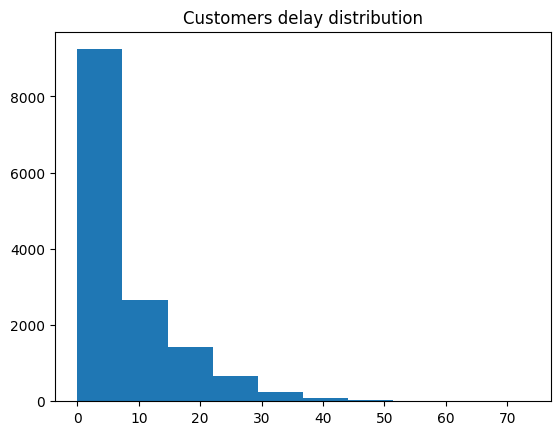

In [79]:
average_customer_delay_time = statistics.mean(bank.customer_delay_times)
print(f"Average Customer delay time = {average_customer_delay_time:.2f} minutes")
plt.hist(list(bank.customer_delay_times), bins=10)
plt.title("Customers delay distribution")
plt.show()

## Average number of customers in the queue E[Q]

Grand Average queue length = 1.88
Average Cashier queue length = 2.23


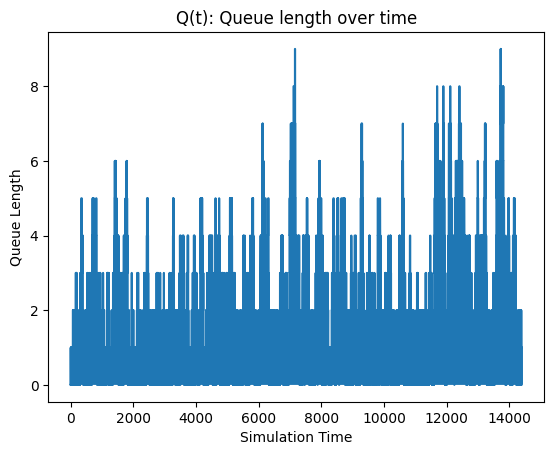

Average Cashier queue length = 2.07


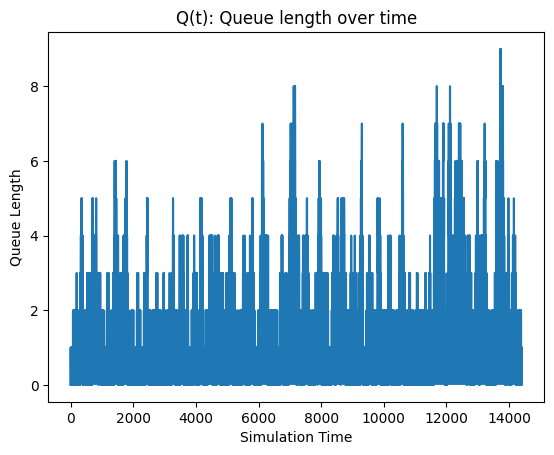

Average Cashier queue length = 1.87


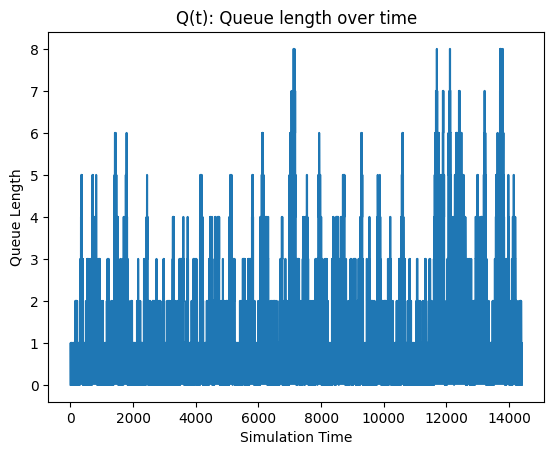

Average Cashier queue length = 1.72


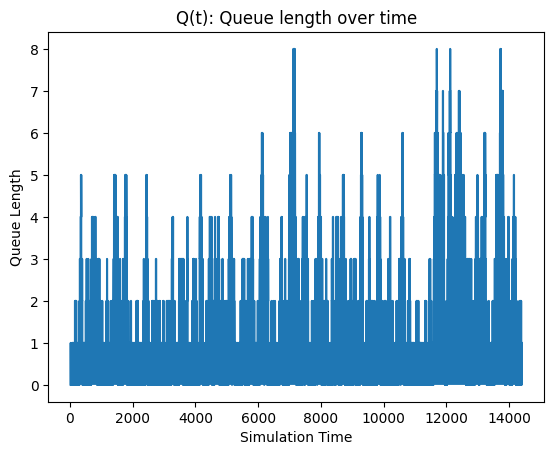

Average Cashier queue length = 1.51


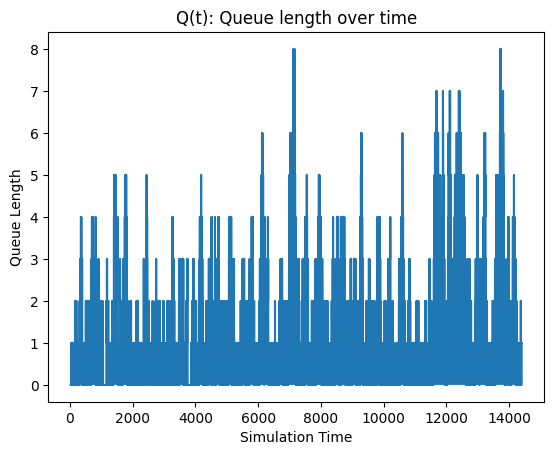

In [72]:
grand_average_queue_length = statistics.mean(
    cashier.average_queue_length for cashier in bank.cashiers
)
print(f"Grand Average queue length = {grand_average_queue_length:.2f}")
for cashier in bank.cashiers:
    average_cashier_queue_length = cashier.average_queue_length
    print(f"Average Cashier queue length = {average_cashier_queue_length:.2f}")
    cashier.plot_qt()

## Server utilization rate E[U]

In [65]:
average_utilization_rate = statistics.fmean(
    cashier.utilization_rate for cashier in bank.cashiers
)
print(f"Average Server Utilization rate E[U] = {average_utilization_rate * 100:.2f}%")
for i, cashier in enumerate(bank.cashiers):
    print(f"  Cashier {i+1} utilization rate = {cashier.utilization_rate * 100:.2f}%")

Average Server Utilization rate E[U] = 89.46%
  Cashier 1 utilization rate = 95.37%
  Cashier 2 utilization rate = 93.25%
  Cashier 3 utilization rate = 90.23%
  Cashier 4 utilization rate = 87.01%
  Cashier 5 utilization rate = 81.45%


In [81]:
jockeying_customers = [
    customer for customer in bank.customers if customer.jockeyed >= 1
]
non_jockeying_customers = [
    customer for customer in bank.customers if customer.jockeyed == 0
]
average_jockeying_customers_delay_time = statistics.mean(
    c.delay for c in jockeying_customers if c.delay is not None
)
average_non_jockeying_customers_delay_time = statistics.mean(
    c.delay for c in non_jockeying_customers if c.delay is not None
)
grand_average_queue_length = statistics.mean(
    cashier.average_queue_length for cashier in bank.cashiers
)
average_customer_delay_time = statistics.mean(bank.customer_delay_times)

print(f"Grand Average queue length = {grand_average_queue_length:.2f}")
print(f"Average Customers delay time = {average_customer_delay_time:.2f} minutes")
average_utilization_rate = statistics.fmean(
    cashier.utilization_rate for cashier in bank.cashiers
)
print(f"Average Server Utilization rate E[U] = {average_utilization_rate * 100:.2f}%")
print(
    f"Average Jockeying Customers delay time = {average_jockeying_customers_delay_time:.2f} minutes"
)
print(
    f"Average Non-Jockeying Customers delay time = {average_non_jockeying_customers_delay_time:.2f} minutes"
)

Grand Average queue length = 1.45
Average Customers delay time = 7.15 minutes
Average Server Utilization rate E[U] = 89.46%
Average Jockeying Customers delay time = 9.85 minutes
Average Non-Jockeying Customers delay time = 7.02 minutes
